# Moneyball ML

This notebook exists to support exploratory data analysis, ad-hoc testing, and visualization. The implementation of the moneyball-ml pipeline exists in [mb.py](mb.py).

In [1]:
import re 
import argparse
from datetime import datetime
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn import metrics
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import torch.optim as optim
from torch.nn import MSELoss 
from torch.optim import SGD
from skorch import NeuralNetRegressor
from skorch.helper import SkorchDoctor

In [2]:
from pybaseball import *
cache.enable()

# Utilities

In [3]:
# Bring in our growing list of utilities and pipeline functions
from data import *
from nn import * 
import mb
import data

# Data

### Catalog

Here are all of the major statistics reported on MLB.com, minus those that blend post-hoc analysis (taints the predictors with run value, wins, etc), composite or less relevant data

- Top Performers : Composite, ignore
- Custom Leaderboards : Composite
- Park Factors : Relevant, but unclear how to incorporate - return to this
- Timer Infractions : Ignore

**Hitting**
- Bat Tracking
- Batted Ball Profile
- Exit Velocity & Barrels
- Expected Statistics
- Home Runs
- Percentile Rankings
- Pitch Arsenal Stats
- Pitch Tempo
- Rolling Windows

**Pitching**
- Active Spin
- Arm Angle
- Bat Tracking
- Exit Velocity & Barrels
- Expected Statistics
- Home Runs
- Percentile Rankings
- Pitch Arsenal Stats - x
- Pitch Arsenals - x
- Pitch Movement
- Pitch Tempo
- Running Game
- Spin Direction - Comparison - x
- Spin Direction - Pitches

**Fielding**
- Arm Strength
- Arm Value
- Catcher Blocking
- Catcher Framing
- Catcher Pop Time
- Catcher Throwing
- Outfield Catch Probability
- Outfield Directional OAA
- Outfielder Jump
- Outs Above Average

**Running**
- Baserunning Run Value
- Basestealing
- Extra Bases Taken
- Sprint Speed

**Positioning**
- Batting Stance
- Batter Positioning
- Fielder - All
- Fielder - Situational
- Pitcher Positioning
- Team Positioning

## Analysis Parameters

In [47]:
year = 2024

## Team Lookup

In [48]:
# No change in teams recently, source from the 2020 data
# Note the trigraph variance between the data sources... fg = FanGraphs, BR = Baseball REfernce, retro = Retrosheet, Lahman = lgID(?) 
teams = team_ids(2020)
teams

,yearID,lgID,teamID,franchID,teamIDfg,teamIDBR,teamIDretro
2875,2020,AL,BAL,BAL,2,BAL,BAL
2876,2020,AL,BOS,BOS,3,BOS,BOS
2877,2020,AL,CHA,CHW,4,CHW,CHA
2878,2020,AL,CLE,CLE,5,CLE,CLE
2879,2020,AL,DET,DET,6,DET,DET
2880,2020,AL,HOU,HOU,21,HOU,HOU
2881,2020,AL,KCA,KCR,7,KCR,KCA
2882,2020,AL,LAA,ANA,1,LAA,ANA
2883,2020,AL,MIN,MIN,8,MIN,MIN
2884,2020,AL,NYA,NYY,9,NYY,NYA


In [49]:
teams.teamID.unique()

array(['BAL', 'BOS', 'CHA', 'CLE', 'DET', 'HOU', 'KCA', 'LAA', 'MIN',
       'NYA', 'OAK', 'SEA', 'TBA', 'TEX', 'TOR', 'ARI', 'ATL', 'CHN',
       'CIN', 'COL', 'LAN', 'MIA', 'MIL', 'NYN', 'PHI', 'PIT', 'SDN',
       'SFN', 'SLN', 'WAS'], dtype=object)

## Player Lookup

In [104]:
register = chadwick_register(save=True)

In [105]:
p = register[register.key_fangraphs == 19470]

In [106]:
if len(p) >= 1: 
    print(p.iloc[0].key_mlbam)

669242


In [108]:
players = register[(register.mlb_played_first <= 2024.0) & (register.mlb_played_last >= 2024.0)]

In [109]:
players.head()

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
21,Miller,Owen,680911,millo002,milleow01,24655,2021.0,2024.0
24,Edman,Tommy,669242,edmat001,edmanto01,19470,2019.0,2025.0
30,Meeker,James,703231,meekj001,meekeja01,-1,2024.0,2024.0
31,Castillo,Diego,660636,castd004,castidi02,19906,2022.0,2024.0
73,Zastryzny,Rob,642239,zastr001,zastrro01,15094,2016.0,2024.0


In [110]:
jwood = players[(players.name_last == 'Wood') & (players.name_first == 'James')]
jwood

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
15788,Wood,James,695578,woodj004,woodja03,-1,2024.0,2025.0


In [111]:
playerid_reverse_lookup([players.iloc[115].key_mlbam])

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,lee,jung hoo,808982,lee-j001,leeju01,33824,2024.0,2025.0


## Spray Chart

In [112]:
batting_df = statcast_batter('2024-01-01', '2024-12-01', 695578)

In [113]:
batting_df

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,KC,2024-09-29,79.6,-1.75,5.17,"Wood, James",695578,605400,strikeout,swinging_strike,...,3,2,6.0,1.0,9.0,NaN,4.81,-1.12,1.12,20.0
1,FF,2024-09-29,93.3,-1.74,5.02,"Wood, James",695578,605400,None,called_strike,...,3,2,6.0,1.0,9.0,NaN,1.54,1.25,-1.25,18.0
2,FF,2024-09-29,92.9,-1.75,5.07,"Wood, James",695578,605400,None,ball,...,3,2,6.0,1.0,9.0,NaN,1.36,1.10,-1.10,17.5
3,KC,2024-09-29,79.8,-1.82,5.10,"Wood, James",695578,605400,None,swinging_strike,...,3,2,6.0,1.0,9.0,NaN,4.66,-1.17,1.17,18.5
4,CH,2024-09-29,87.7,-1.75,5.00,"Wood, James",695578,605400,None,ball,...,3,2,6.0,1.0,9.0,NaN,2.11,1.23,-1.23,18.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1572,ST,2024-02-25,86.3,-0.79,5.94,"Wood, James",695578,676534,None,ball,...,1,2,NaN,NaN,NaN,NaN,2.93,-0.46,0.46,NaN
1573,FF,2024-02-25,93.6,-0.83,6.15,"Wood, James",695578,676534,None,ball,...,1,2,NaN,NaN,NaN,NaN,1.16,0.39,-0.39,NaN
1574,None,2024-02-24,NaN,NaN,NaN,"Wood, James",695578,680423,field_out,hit_into_play,...,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1575,None,2024-02-24,NaN,NaN,NaN,"Wood, James",695578,685377,home_run,hit_into_play,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/Users/jason/Local/school/520/moneyball-ml/venv3.12/lib/python3.12/site-packages/pybaseball/plotting.py:138: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_data = sub_data[sub_data['events'].notna()][sub_data['hc_x'].notna()][sub_data['hc_y'].notna()]
/Users/jason/Local/school/520/moneyball-ml/venv3.12/lib/python3.12/site-packages/pybaseball/plotting.py:138: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_data = sub_data[sub_data['events'].notna()][sub_data['hc_x'].notna()][sub_data['hc_y'].notna()]


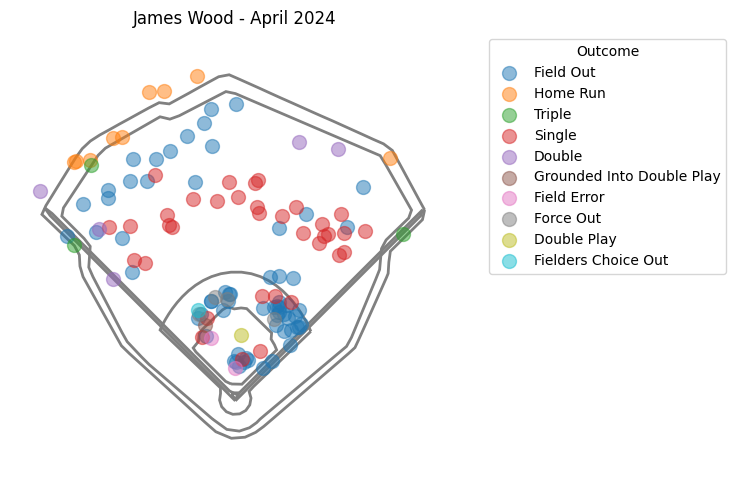

<Axes: title={'center': 'James Wood - April 2024'}>

In [114]:
spraychart(batting_df[batting_df['home_team'] == 'WSH'], 'nationals', title='James Wood - April 2024')

## Strike Zone

In [ ]:
players[players.name_last == 'Gore']

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
16740,Gore,MacKenzie,669022,gorem001,gorema01,22201,2022.0,2025.0


In [ ]:
early = statcast_pitcher('2024-04-01', '2024-04-30', 669022)
late = statcast_pitcher('2024-08-01', '2024-08-31', 669022)

Gathering Player Data
Gathering Player Data


In [ ]:
data.pitch_type.unique()

array(['KC', 'FF', 'CH', 'CU', 'SL', 'SI', 'FS', 'FC', 'ST', 'SV', 'CS',
       'KN', nan], dtype=object)

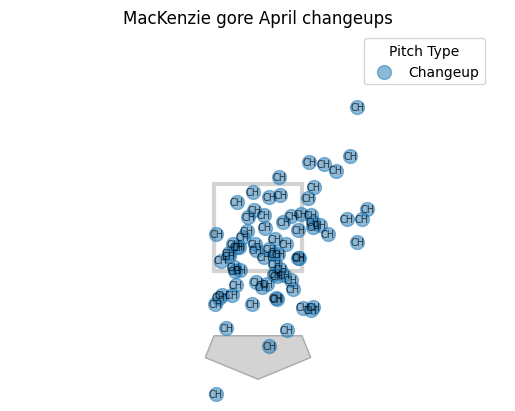

<Axes: title={'center': 'MacKenzie gore April changeups'}>

In [ ]:
plot_strike_zone(early[early.pitch_type == 'CH'], title = "MacKenzie gore April changeups")

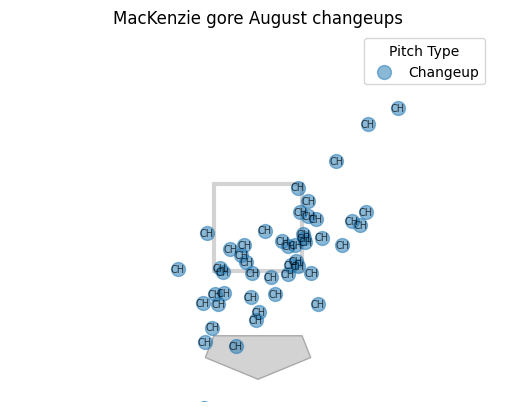

<Axes: title={'center': 'MacKenzie gore August changeups'}>

In [ ]:
plot_strike_zone(late[late.pitch_type == 'CH'], title = "MacKenzie gore August changeups")

## Schedule and Results

In [ ]:
# This is a baseball reference lookup, use the correct trigraph... 
teams.teamIDBR.unique()

array(['BAL', 'BOS', 'CHW', 'CLE', 'DET', 'HOU', 'KCR', 'LAA', 'MIN',
       'NYY', 'OAK', 'SEA', 'TBR', 'TEX', 'TOR', 'ARI', 'ATL', 'CHC',
       'CIN', 'COL', 'LAD', 'MIA', 'MIL', 'NYM', 'PHI', 'PIT', 'SDP',
       'SFG', 'STL', 'WSN'], dtype=object)

Interesting to note Washington shows as WSN, WAS and WSH - may need to do some wildcarding depending on the data source

In [ ]:
results = pd.DataFrame()
for team in teams.teamIDBR.unique(): 
    print(f"Retrieving results for {team}...")
    team_results = schedule_and_record(2024, team)
    results = pd.concat([results, team_results])

In [ ]:
results.shape

(4858, 20)

Just 2 games short of the theoretical 162 scheduled games * 30 teams... checks out!

In [ ]:
results.head()

,Date,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,GB,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled
1,"Thursday, Mar 28",BAL,Home,LAA,W,11.0,3.0,9.0,1-0,1.0,Tied,Burnes,Sandoval,None,2:43,D,45029.0,.95,1.0,None
2,"Saturday, Mar 30",BAL,Home,LAA,W,13.0,4.0,9.0,2-0,2.0,0.5,Rodriguez,Canning,None,2:55,D,28420.0,.98,2.0,None
3,"Sunday, Mar 31",BAL,Home,LAA,L,1.0,4.0,9.0,2-1,2.0,1.5,Detmers,Wells,Estévez,2:19,D,20576.0,1.01,-1.0,None
4,"Monday, Apr 1",BAL,Home,KCR,W-wo,6.0,4.0,9.0,3-1,2.0,1.5,Kimbrel,Anderson,None,2:35,N,12666.0,.94,1.0,None
5,"Tuesday, Apr 2",BAL,Home,KCR,L,1.0,4.0,9.0,3-2,3.0,1.5,Marsh,Irvin,Smith,2:17,N,9404.0,1.00,-1.0,None


## Statcast Metrics

See documentation here: https://github.com/jldbc/pybaseball/blob/master/docs/statcast.md

### Pitching

In [53]:
sc_df = statcast("2024-04-01", "2024-04-30")

This is a large query, it may take a moment to complete


100%|██████████| 30/30 [00:01<00:00, 26.46it/s]


In [54]:
sc_df

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
2825,CH,2024-04-30,81.2,-2.75,5.42,"Crismatt, Nabil",572233,622503,home_run,hit_into_play,...,1,4,2,1,12,1,3.26,0.77,0.77,30.6
2898,CH,2024-04-30,81.4,-2.73,5.47,"Crismatt, Nabil",572233,622503,None,ball,...,1,4,2,1,12,1,2.94,0.43,0.43,30.0
3061,CH,2024-04-30,82.0,-2.63,5.6,"Crismatt, Nabil",572233,622503,None,called_strike,...,1,4,2,1,12,1,3.04,0.68,0.68,34.1
2405,SL,2024-04-30,87.8,-1.57,6.03,"McGough, Scott",606192,543518,field_out,hit_into_play,...,1,4,1,1,3,1,2.62,-0.36,-0.36,46.3
2435,FF,2024-04-30,93.6,-1.49,6.03,"McGough, Scott",606192,543518,None,ball,...,1,4,1,1,3,1,1.0,0.66,0.66,45.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3672,FF,2024-04-01,97.5,1.77,5.84,"Gore, MacKenzie",656582,669022,None,ball,...,1,0,<NA>,1,6,3,0.95,0.57,-0.57,44.6
3746,FF,2024-04-01,98.6,2.02,5.88,"Gore, MacKenzie",656582,669022,None,ball,...,1,0,<NA>,1,6,3,0.91,0.7,-0.7,40.7
3898,FF,2024-04-01,97.7,2.05,5.83,"Gore, MacKenzie",656582,669022,None,foul,...,1,0,<NA>,1,6,3,0.72,0.36,-0.36,40.4
4016,FF,2024-04-01,96.8,2.1,5.84,"Gore, MacKenzie",656582,669022,None,ball,...,1,0,<NA>,1,6,3,0.91,0.55,-0.55,39.8


In [24]:
sc_pitching = data.load_sc_pitching_base(2024, 'data/')

In [25]:
def unique_vals(df): 
    for c in df.columns: 
        print(c, df[c].unique())

In [ ]:
g = sc_pitching.groupby('pitcher')
g.head()

In [52]:
batting_df

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,KC,2024-09-29,79.6,-1.75,5.17,"Wood, James",695578,605400,strikeout,swinging_strike,...,3,2,6.0,1.0,9.0,NaN,4.81,-1.12,1.12,20.0
1,FF,2024-09-29,93.3,-1.74,5.02,"Wood, James",695578,605400,None,called_strike,...,3,2,6.0,1.0,9.0,NaN,1.54,1.25,-1.25,18.0
2,FF,2024-09-29,92.9,-1.75,5.07,"Wood, James",695578,605400,None,ball,...,3,2,6.0,1.0,9.0,NaN,1.36,1.10,-1.10,17.5
3,KC,2024-09-29,79.8,-1.82,5.10,"Wood, James",695578,605400,None,swinging_strike,...,3,2,6.0,1.0,9.0,NaN,4.66,-1.17,1.17,18.5
4,CH,2024-09-29,87.7,-1.75,5.00,"Wood, James",695578,605400,None,ball,...,3,2,6.0,1.0,9.0,NaN,2.11,1.23,-1.23,18.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1572,ST,2024-02-25,86.3,-0.79,5.94,"Wood, James",695578,676534,None,ball,...,1,2,NaN,NaN,NaN,NaN,2.93,-0.46,0.46,NaN
1573,FF,2024-02-25,93.6,-0.83,6.15,"Wood, James",695578,676534,None,ball,...,1,2,NaN,NaN,NaN,NaN,1.16,0.39,-0.39,NaN
1574,None,2024-02-24,NaN,NaN,NaN,"Wood, James",695578,680423,field_out,hit_into_play,...,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1575,None,2024-02-24,NaN,NaN,NaN,"Wood, James",695578,685377,home_run,hit_into_play,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
df_velo = pybaseball.statcast_pitcher_exitvelo_barrels(2023, minBBE=1)

In [ ]:
df_velo.head()

,"last_name, first_name",player_id,attempts,avg_hit_angle,anglesweetspotpercent,max_hit_speed,avg_hit_speed,ev50,fbld,gb,max_distance,avg_distance,avg_hr_distance,ev95plus,ev95percent,barrels,brl_percent,brl_pa
0,"Mikolas, Miles",571945,674,15.0,38.9,115.5,90.4,80.2,93.7,88.0,479,180,404.0,290,43.0,66,9.8,7.7
1,"Webb, Logan",657277,619,0.6,28.3,114.2,90.7,79.7,95.0,88.8,483,120,403.0,285,46.0,43,6.9,5.1
2,"Corbin, Patrick",571578,605,11.7,37.5,116.3,90.7,80.2,94.2,87.9,444,167,403.0,266,44.0,56,9.3,7.1
3,"Gibson, Kyle",502043,589,8.2,33.3,113.3,89.7,78.4,93.9,86.7,436,151,400.0,262,44.5,45,7.6,5.6
4,"Lyles, Jordan",543475,575,19.8,34.6,115.0,89.0,78.6,92.8,86.1,445,184,402.0,204,35.5,57,9.9,7.6


In [14]:
sc_pitcher_ev = data.load_statcast_pitching_velo(2023, 'data/')

AttributeError: module 'data' has no attribute 'load_statcast_pitching_velo'

In [ ]:
sc_pitcher_expected = statcast_pitcher_expected_stats(year)
sc_pitcher_expected.columns

NameError: name 'year' is not defined

In [ ]:
# Aggregate 
sc_pitch_spin = pd.read_csv("data/active_spin_2024.csv")
sc_pitch_spin

,"last_name, first_name",pitch_hand,active_spin_fourseam,active_spin_sinker,active_spin_cutter,active_spin_changeup,active_spin_splitter,active_spin_curve,active_spin_slider,active_spin_sweeper,active_spin_slurve
0,"Roberts, Ethan",R,NaN,60.2,45.6,NaN,NaN,NaN,NaN,69.5,NaN
1,"Uribe, Abner",R,NaN,69.9,NaN,NaN,NaN,NaN,34.7,NaN,NaN
2,"Ashby, Aaron",L,NaN,83.9,NaN,77.0,NaN,88.1,45.9,NaN,NaN
3,"Bowman, Matt",R,NaN,89.6,60.3,NaN,81.9,NaN,NaN,49.5,NaN
4,"Peguero, Elvis",R,NaN,94.3,NaN,NaN,NaN,NaN,25.6,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
703,"Cimber, Adam",R,57.3,63.7,NaN,NaN,NaN,NaN,68.2,NaN,NaN
704,"Adams, Austin",R,55.9,54.1,NaN,NaN,NaN,NaN,33.6,NaN,NaN
705,"Cosgrove, Tom",L,55.1,59.1,NaN,NaN,NaN,NaN,NaN,60.6,NaN
706,"Turnbull, Spencer",R,53.3,71.7,NaN,90.0,NaN,87.6,40.9,48.6,NaN


In [ ]:
sc_pitch_spin.index

RangeIndex(start=0, stop=708, step=1)

In [ ]:
# Pitch movement is not a valid symbol in the package despite the docs - pull from baseballsavant.mlb.com manually
sc_pitch_movement = pd.read_csv("data/pitch_movement_2024.csv")
unique_vals(sc_pitch_movement)

year [2024]
last_name, first_name ['Gore, MacKenzie' 'Peralta, Freddy' 'Rodón, Carlos' 'Gausman, Kevin'
 'Greene, Hunter' 'Heaney, Andrew' 'Cease, Dylan' 'Kikuchi, Yusei'
 'Burnes, Corbin' 'Imanaga, Shota' 'Nelson, Ryne' 'Sánchez, Cristopher'
 'Ragans, Cole' 'Cortes, Nestor' 'Gil, Luis' 'Castillo, Luis'
 'Wheeler, Zack' 'Crochet, Garrett' 'Webb, Logan' 'Abbott, Andrew'
 'Bibee, Tanner' 'Singer, Brady' 'Steele, Justin' 'Bassitt, Chris'
 'Valdez, Framber' 'López, Pablo' 'Harrison, Kyle' 'Morton, Charlie'
 'Parker, Mitchell' 'López, Reynaldo' 'Gallen, Zac' 'Pivetta, Nick'
 'Anderson, Tyler' 'Miller, Bryce' 'Irvin, Jake' 'Sale, Chris'
 'Flaherty, Jack' 'Houck, Tanner' 'Suárez, Albert' 'Bello, Brayan'
 'Pepiot, Ryan' 'Canning, Griffin' 'Gomber, Austin' 'Blanco, Ronel'
 'Nola, Aaron' 'Flexen, Chris' 'Corbin, Patrick' 'Estes, Joey' 'Sears, JP'
 'Severino, Luis' 'Ober, Bailey' 'Kirby, George' 'Ryan, Joe'
 'Arrighetti, Spencer' 'Hicks, Jordan' 'Falter, Bailey' 'Brown, Hunter'
 'Spence, Mitch' '

### Batting

In [ ]:
# Batting data!
sc_james_wood = statcast_batter("2024-1-1", "2024-12-31", 695578)

### Fielding 

See docs here: https://github.com/jldbc/pybaseball/blob/master/docs/statcast_fielding.md

In [ ]:
# Aggregate outs above average for the year
sc_fielding_oaa = statcast_outfield_directional_oaa(year, min_opp=1)
sc_fielding_oaa

,"last_name, first_name",player_id,attempts,n_outs_above_average,n_oaa_slice_back_left,n_oaa_slice_back,n_oaa_slice_back_right,n_oaa_slice_back_all,n_oaa_slice_in_left,n_oaa_slice_in,n_oaa_slice_in_right,n_oaa_slice_in_all
0,"Young, Jacob",696285,409,19,1,-2,2,2,5,5,7,18
1,"Varsho, Daulton",662139,348,16,3,4,4,11,2,2,1,5
2,"Siri, Jose",642350,355,16,2,0,2,4,3,4,5,12
3,"Siani, Michael",672279,255,16,3,1,4,8,2,2,5,8
4,"Doyle, Brenton",686668,448,15,3,5,3,11,0,1,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...
297,"Hernández, Teoscar",606192,337,-9,-2,0,-3,-5,1,-2,-2,-4
298,"Burleson, Alec",676475,147,-9,-3,0,-1,-5,-1,-2,-2,-5
299,"Winker, Jesse",608385,163,-11,-2,-2,-3,-7,-1,-2,-1,-4
300,"García, Adolis",666969,297,-12,-4,-3,-1,-8,-2,1,-2,-3


In [ ]:
# Outfield catch probability is an aggregate statistic, these represent the totality of performance for the individual in the year queried
sc_catch_prob = statcast_outfield_catch_prob(year, min_opp=1)
sc_catch_prob

,"last_name, first_name",player_id,oaa,n_fieldout_5stars,n_opp_5stars,n_5star_percent,n_fieldout_4stars,n_opp_4stars,n_4star_percent,n_fieldout_3stars,n_opp_3stars,n_3star_percent,n_fieldout_2stars,n_opp_2stars,n_2star_percent,n_fieldout_1stars,n_opp_1stars,n_1star_percent
0,"Young, Jacob",696285,19,6,17,35.3,13,18,72.2,15,16,93.8,23,26,88.5,26,26,100.0
1,"Varsho, Daulton",662139,16,3,21,14.3,6,11,54.5,18,22,81.8,22,23,95.7,36,36,100.0
2,"Siri, Jose",642350,16,4,9,44.4,9,16,56.3,22,26,84.6,19,20,95.0,22,24,91.7
3,"Siani, Michael",672279,16,4,16,25.0,5,5,100.0,16,18,88.9,18,18,100.0,22,22,100.0
4,"Doyle, Brenton",686668,15,0,19,0.0,7,14,50.0,24,27,88.9,30,32,93.8,40,40,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,"Hernández, Teoscar",606192,-9,0,24,0.0,1,12,8.3,4,9,44.4,24,29,82.8,28,30,93.3
298,"Burleson, Alec",676475,-9,0,6,0.0,0,7,0.0,0,6,0.0,4,5,80.0,11,13,84.6
299,"Winker, Jesse",608385,-11,0,9,0.0,1,12,8.3,5,9,55.6,6,12,50.0,17,20,85.0
300,"García, Adolis",666969,-12,0,16,0.0,1,10,10.0,5,16,31.3,11,14,78.6,22,25,88.0


In [ ]:
# Catch pop time - throws from release to arrival at targeted base
sc_pop_time = statcast_catcher_poptime(year, min_2b_att=1, min_3b_att=1)
sc_pop_time

,catcher,player_id,team_id,age,maxeff_arm_2b_3b_sba,exchange_2b_3b_sba,pop_2b_sba_count,pop_2b_sba,pop_2b_cs,pop_2b_sb,pop_3b_sba_count,pop_3b_sba,pop_3b_cs,pop_3b_sb
0,"Bailey, Patrick",NaN,137,25,84.6,0.60,58,1.85,1.83,1.86,2,1.40,1.42,1.37
1,"Realmuto, J.T.",NaN,143,33,85.1,0.65,39,1.85,1.85,1.84,4,1.42,1.41,1.45
2,"Lee, Korey",NaN,145,25,88.3,0.64,46,1.85,1.85,1.85,2,1.49,1.56,1.42
3,"Fermin, Freddy",NaN,118,29,84.3,0.64,23,1.88,1.85,1.92,2,1.54,NaN,1.54
4,"Jackson, Alex",NaN,139,28,85.0,0.66,26,1.96,1.86,1.99,2,1.39,NaN,1.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,"Amaya, Miguel",NaN,112,25,80.5,0.70,50,2.04,2.08,2.03,2,1.57,1.64,1.49
69,"Barnes, Austin",NaN,119,34,75.9,0.58,27,2.00,2.09,1.99,2,1.49,1.46,1.52
70,"Del Castillo, Adrian",NaN,109,24,76.9,0.69,13,2.04,2.18,2.02,1,1.60,NaN,1.60
71,"Reetz, Jakson",NaN,137,28,80.3,0.77,3,2.11,NaN,2.11,1,1.53,NaN,1.53


In [ ]:
# Catcher framing
sc_framing = statcast_catcher_framing(year, min_called_p=1)
sc_framing

,last_name,first_name,player_id,year,n_called_pitches,runs_extra_strikes,strike_rate,strike_rate_11,strike_rate_12,strike_rate_13,strike_rate_14,strike_rate_16,strike_rate_17,strike_rate_18,strike_rate_19
0,League Average,None,NaN,2024,144792,0,46.4,18.9,48.1,23.1,58.8,65.7,29.2,49.2,23.4
1,Bailey,Patrick,672275.0,2024,3214,16,52.5,23.3,57.4,28.4,64.6,70.5,29.8,54.8,32.2
2,Raleigh,Cal,663728.0,2024,3404,13,49.1,22.4,55.0,30.0,60.9,68.5,30.0,46.3,28.4
3,Wells,Austin,669224.0,2024,3111,12,48.6,23.0,49.3,23.9,58.1,66.0,31.5,55.1,29.3
4,Kirk,Alejandro,672386.0,2024,2586,10,49.8,21.7,50.7,21.9,67.3,61.2,34.6,56.1,28.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Diaz,Yainer,673237.0,2024,3083,-7,45.2,19.4,54.4,26.6,61.6,62.7,23.0,40.8,22.4
97,Lee,Korey,686676.0,2024,2990,-7,43.0,18.9,45.5,13.7,60.2,60.6,23.2,48.6,19.3
98,Jeffers,Ryan,680777.0,2024,2280,-7,44.6,19.2,50.5,19.2,55.7,59.5,31.0,52.0,15.6
99,Campusano,Luis,669134.0,2024,2130,-8,44.0,17.7,49.7,20.7,46.7,69.1,25.2,48.0,24.4


In [ ]:
# Fielding run value is an aggregate score -- should we employ or does it just pollute the raw predictors? 

### Running

In [ ]:
sc_sprint = statcast_sprint_speed(year, min_opp=1)

In [ ]:
sc_sprint.shape

(606, 10)

In [ ]:
# Aggregate metric, not applicable to any time series
sc_sprint.head()

,"last_name, first_name",player_id,team_id,team,position,age,competitive_runs,bolts,hp_to_1b,sprint_speed
0,"Witt Jr., Bobby",677951,118,KC,SS,24,298,156.0,4.10,30.5
1,"Rojas, Johan",679032,143,PHI,CF,23,176,78.0,4.24,30.1
2,"De La Cruz, Elly",682829,113,CIN,SS,22,249,81.0,4.21,30.0
3,"Fitzgerald, Tyler",666149,137,SF,SS,26,99,47.0,4.30,30.0
4,"Clase, Jonatan",682729,141,TOR,LF,22,20,8.0,NaN,30.0


## Conventional Metrics

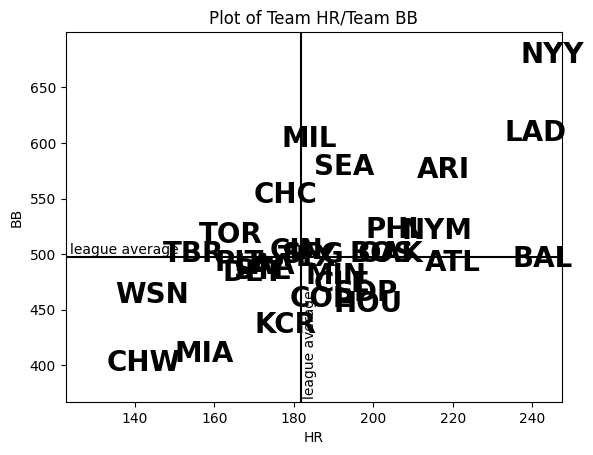

In [ ]:
# https://github.com/jldbc/pybaseball/blob/master/docs/plotting.md
data = team_batting(2024)
plot_teams(data, "HR", "BB")

In [358]:
# API documentation at https://github.com/jldbc/pybaseball/blob/master/docs/batting_stats.md
batting = batting_stats(2023, qual=1)

In [359]:
batting

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR
13,18401,2023,Ronald Acuna Jr.,ATL,25,159,643,735,217,137,...,121.2,310,0.552,562,0.137,0.214,0.357,0.660,0.460,8.5
20,5361,2023,Freddie Freeman,LAD,33,161,637,730,211,121,...,110.6,218,0.418,521,0.114,0.208,0.323,0.565,0.408,7.9
17,13611,2023,Mookie Betts,LAD,30,152,584,693,179,99,...,110.1,232,0.481,482,0.205,0.262,0.294,0.563,0.407,8.3
19,14344,2023,Matt Olson,ATL,29,162,608,720,172,88,...,118.6,245,0.551,445,0.130,0.249,0.264,0.558,0.392,6.7
11,19755,2023,Shohei Ohtani,LAA,28,135,497,599,151,73,...,118.6,193,0.533,362,0.125,0.264,0.295,0.638,0.427,6.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,5933,2023,Jean Segura,MIA,33,85,301,326,66,56,...,114.0,99,0.388,255,0.176,0.268,0.239,0.340,0.281,-1.3
550,20970,2023,Oscar Gonzalez,CLE,25,54,173,180,37,26,...,113.0,52,0.406,128,0.134,0.301,0.237,0.362,0.271,-1.6
494,19901,2023,Gavin Sheets,CHW,27,118,311,344,63,43,...,109.5,81,0.325,249,0.151,0.243,0.210,0.339,0.267,-1.4
501,14691,2023,Harold Castro,COL,29,99,258,270,65,51,...,106.1,56,0.287,195,0.142,0.292,0.242,0.338,0.263,-1.5


In [20]:
data.find_player(name=('Ohtani', 'Shohei'))

np.int64(660271)

In [21]:
batting[batting.IDfg==19755]

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR
11,19755,2023,Shohei Ohtani,LAA,28,135,497,599,151,73,...,118.6,193,0.533,362,0.125,0.264,0.295,0.638,0.427,6.6


In [57]:
pitching = pitching_stats(2024, qual=50)

In [58]:
pitching.shape

(351, 393)

In [59]:
len(pitching)

351

In [60]:
pitching.head()

,IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,...,Pit+ FC,Stf+ FS,Loc+ FS,Pit+ FS,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO
25,10603,2024,Chris Sale,ATL,35,18,3,6.4,2.38,29,...,NaN,NaN,NaN,NaN,111,106,112,NaN,NaN,NaN
26,22267,2024,Tarik Skubal,DET,27,18,4,5.9,2.39,31,...,NaN,NaN,NaN,NaN,113,102,115,NaN,NaN,NaN
33,10310,2024,Zack Wheeler,PHI,34,16,7,5.4,2.57,32,...,92.0,95.0,102.0,93.0,109,104,113,NaN,NaN,NaN
77,21846,2024,Cole Ragans,KCR,26,11,9,4.9,3.14,32,...,101.0,NaN,NaN,NaN,112,98,111,NaN,NaN,NaN
117,18525,2024,Dylan Cease,SDP,28,14,11,4.8,3.47,33,...,92.0,NaN,NaN,NaN,110,104,114,NaN,NaN,NaN


In [62]:
pitching[pitching.Team=="LAD"]

,IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,...,Pit+ FC,Stf+ FS,Loc+ FS,Pit+ FS,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO
120,14374,2024,Tyler Glasnow,LAD,30,9,6,3.8,3.49,22,...,NaN,NaN,NaN,NaN,108,101,114,NaN,NaN,NaN
62,33825,2024,Yoshinobu Yamamoto,LAD,25,7,2,2.8,3.00,18,...,108.0,112.0,101.0,109.0,98,106,105,NaN,NaN,NaN
128,27792,2024,Gavin Stone,LAD,25,11,5,2.0,3.53,25,...,95.0,NaN,NaN,NaN,98,102,102,NaN,NaN,NaN
5,25007,2024,Alex Vesia,LAD,28,5,4,1.1,1.76,67,...,NaN,NaN,NaN,NaN,113,99,111,NaN,NaN,NaN
146,17734,2024,Evan Phillips,LAD,29,5,1,0.9,3.62,61,...,101.0,NaN,NaN,NaN,112,104,115,NaN,NaN,NaN
153,27487,2024,Landon Knack,LAD,26,3,5,0.5,3.65,15,...,NaN,NaN,NaN,NaN,94,103,98,NaN,NaN,NaN
311,23221,2024,Michael Grove,LAD,27,4,4,0.4,5.12,39,...,107.0,NaN,NaN,NaN,102,105,109,NaN,NaN,NaN
63,7146,2024,Daniel Hudson,LAD,37,6,2,0.2,3.00,65,...,NaN,NaN,NaN,NaN,104,105,105,NaN,NaN,NaN
320,19374,2024,Walker Buehler,LAD,29,1,6,-0.2,5.38,16,...,115.0,NaN,NaN,NaN,100,96,99,NaN,NaN,NaN
350,27483,2024,Bobby Miller,LAD,25,2,4,-0.9,8.52,13,...,NaN,NaN,NaN,NaN,103,94,100,NaN,NaN,NaN


In [63]:
pitching[pitching.Name=="Shohei Ohtani"]

,IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,...,Pit+ FC,Stf+ FS,Loc+ FS,Pit+ FS,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO


## Reference Prediction

Naive approach to modeling, merge every feature in and throw an algorithm at it... 

We still need to decide how the data will be composed and made available to the algorithm! Player specific stats are numerous, and create a hierarchical relationship ... perhaps we need to group hitter data and use unsupervised techniques to compress, then do the same for pitchers, runners, fielders ... in this way the predictors are all mashups of those tributary tables. 

- Is there a role for supervised learning in the tributary tables? 

In [47]:
std22 = load_standard(2022)
std23 = load_standard(2023)
std24 = load_standard(2024)

In [50]:
std22.shape

(692, 135)

In [49]:
std23.shape

(650, 135)

In [51]:
std24.shape

(559, 135)

In [43]:
sc22 = load_statcast(2022)
sc23 = load_statcast(2023)
sc24 = load_statcast(2024)

This is a large query, it may take a moment to complete


100%|██████████| 183/183 [00:09<00:00, 18.58it/s]
/Users/jason/Local/school/520/moneyball-ml/venv3.12/lib/python3.12/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


This is a large query, it may take a moment to complete


100%|██████████| 183/183 [00:09<00:00, 18.78it/s]
/Users/jason/Local/school/520/moneyball-ml/venv3.12/lib/python3.12/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


In [44]:
sc22.shape

(1531, 197)

In [45]:
sc23.shape

(1311, 197)

In [46]:
sc24.shape

(1323, 197)

# Modeling

Preponderance of modeling experiments are run out of the mb.py tool. 

In [31]:
import skorch 
import torch 
import importlib 
from data import *
importlib.reload(data)
importlib.reload(mb) 

<module 'mb' from '/Users/jason/Local/school/520/moneyball-ml/mb.py'>

In [10]:
mb.gpu_survey()

GPU resources not found!


False

MSE LR: 12.59


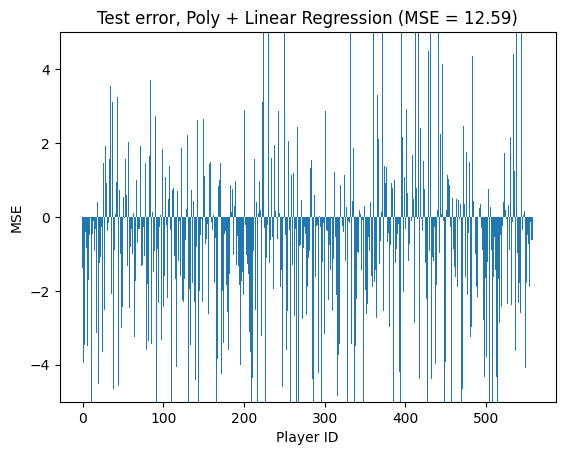

MSE LR: 1.02


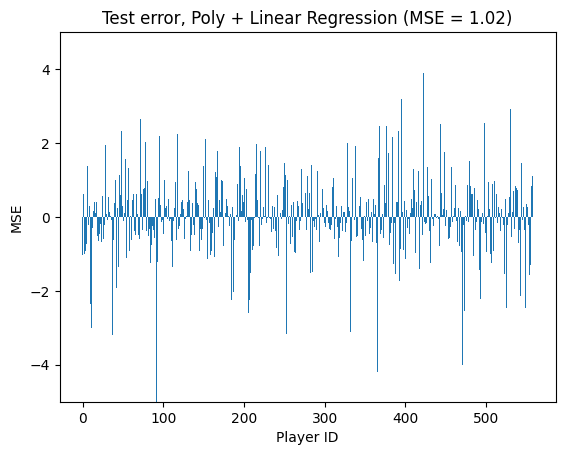

ValueError: Inconsistent data and label lengths, aborting run!

In [99]:
dsets = [(True, False), (True, True), (False, True)]

for dset in dsets: 

    X_train, y_train, X_test, y_test = mb.build_train_test_set(standard=dset[0], statcast=dset[1])

    # LR
    pf = PolynomialFeatures()
    X_train_poly = pf.fit_transform(X_train)
    lr = LinearRegression()
    lr.fit(X_train_poly, y_train)
    preds = lr.predict(pf.transform(X_test))
    mse = metrics.mean_squared_error(y_test, preds)
    print(f"MSE LR: {mse:.2f}")

    #plt.bar(x=X_test.index, height=y_test) 
    #lt.bar([x for x in range(0,len(X_test.index))], height=preds, width=1)
    #plt.bar([x for x in range(0,len(X_test.index))], height=y_test, width=1)
    plt.bar([x for x in range(0,len(X_test.index))], height=y_test-preds, width=1)    
    plt.title(f"Test error, Poly + Linear Regression (MSE = {mse:.2f})")
    plt.ylim(-5,5)
    plt.xlabel("Player ID")
    plt.ylabel("MSE")
    plt.show()


In [93]:
preds

array([[ 4.80201542e-01],
       [ 1.98366845e+00],
       [ 6.16651356e-01],
       [ 8.26753229e-02],
       [ 3.82301033e-01],
       [ 1.14635491e+00],
       [ 1.53250885e+00],
       [-1.05521396e-01],
       [-2.66354769e-01],
       [-1.74218178e-01],
       [ 4.33386421e+00],
       [ 4.20435143e+00],
       [ 6.16413057e-01],
       [-1.48304850e-01],
       [-2.38675952e-01],
       [ 1.01968539e+00],
       [-5.12259245e-01],
       [ 2.41961598e+00],
       [ 5.41951120e-01],
       [ 1.06999171e+00],
       [ 1.87608111e+00],
       [ 9.79429483e-02],
       [-1.07967541e-01],
       [ 4.38587904e-01],
       [ 1.81554306e+00],
       [ 1.29841578e+00],
       [-5.12501955e-01],
       [ 2.32012868e-02],
       [ 1.47119999e+00],
       [ 1.65230238e+00],
       [-4.45503473e-01],
       [-1.26706570e-01],
       [ 8.59340489e-01],
       [-2.09693953e-01],
       [ 1.17125356e+00],
       [ 1.30460870e+00],
       [-2.27102727e-01],
       [ 4.59600115e+00],
       [ 6.2

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.8614        2.3740  0.0290
      2        2.3373        2.0201  0.0292
      3        2.0007        1.8466  0.0269
      4        1.7981        1.7469  0.0286
      5        1.6492        1.6663  0.0267
      6        1.5245        1.5635  0.0267
      7        1.4166        1.4828  0.0259
      8        1.3263        1.4311  0.0266
      9        1.2496        1.3969  0.0261
     10        1.1915        1.3460  0.0267
     11        1.1459        1.3106  0.0275
     12        1.1057        1.2552  0.0255
     13        1.0762        1.2506  0.0289
     14        1.0506        1.2497  0.0325
     15        1.0291        1.1946  0.0316
     16        1.0078        1.1866  0.0329
     17        0.9920        1.1497  0.0343
     18        0.9739        1.1234  0.0340
     19        0.9591        1.1018  0.0376
     20        0.9462        1.1191  0.0364
     21        0.9296        1.1

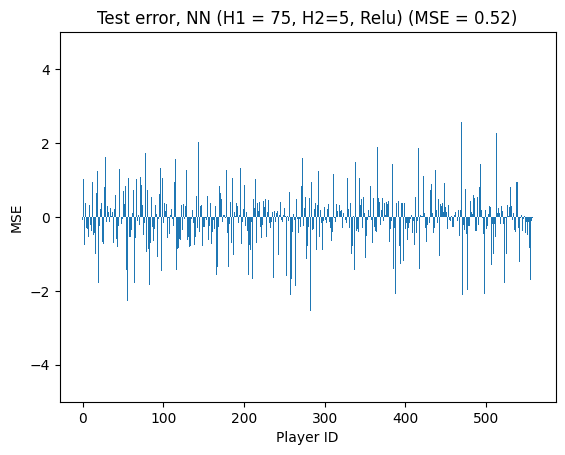

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.6362        2.0142  0.0292
      2        1.8865        1.7750  0.0339
      3        1.6122        1.6024  0.0331
      4        1.4045        1.4434  0.0287
      5        1.2654        1.3746  0.0278
      6        1.1597        1.3480  0.0311
      7        1.0983        1.3174  0.0284
      8        1.0518        1.3812  0.0286
      9        1.0299        1.2682  0.0285
     10        0.9947        1.2542  0.0289
     11        0.9668        1.1774  0.0294
     12        0.9442        1.1507  0.0287
     13        0.9298        1.1585  0.0305
     14        0.9008        1.1191  0.0289
     15        0.8800        1.1263  0.0314
     16        0.8607        1.0827  0.0332
     17        0.8452        1.0882  0.0324
     18        0.8243        1.0761  0.0288
     19        0.8093        1.0643  0.0291
     20        0.7946        1.0413  0.0299
     21        0.7661        1.0

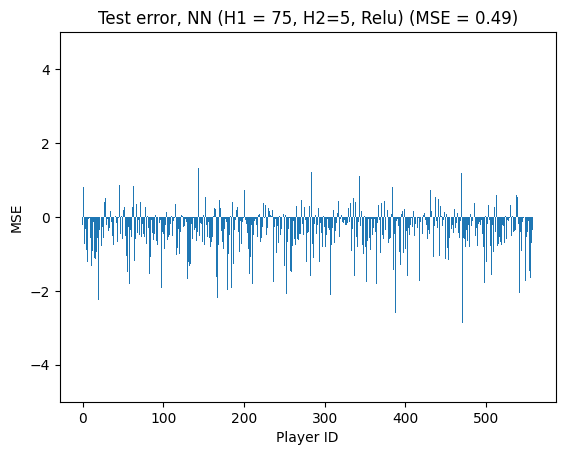

ValueError: Inconsistent data and label lengths, aborting run!

In [100]:
dsets = [(True, False), (True, True), (False, True)]

for dset in dsets: 

    X_train, y_train, X_test, y_test = mb.build_train_test_set(standard=dset[0], statcast=dset[1])

    # NN 
    nn_input_size = len(X_train.columns)
    net= skorch.NeuralNetRegressor(
            module=WARNet, 
            criterion=torch.nn.MSELoss, 
            optimizer=torch.optim.SGD, 
            max_epochs=200, 
            lr=0.001, 
            module__n_input=nn_input_size, 
            module__n_hidden1=75, 
            batch_size=5, 
            iterator_train__shuffle=True)
    
    X_train_nn, y_train_nn = mb.make_nn_set(X_train, y_train)    

    net.fit(X_train_nn, y_train_nn)

    X_test_nn, _ = mb.make_nn_set(X_test, y_test)
    preds = net.predict(X_test_nn)
    mse = metrics.mean_squared_error(y_test, preds.flatten())
    print(f"MSE NN: {mse:.2f}")
    
    plt.bar([x for x in range(0,len(X_test.index))], height=y_test-preds.flatten(), width=1)    
    plt.title(f"Test error, NN (H1 = 75, H2=5, Relu) (MSE = {mse:.2f})")
    plt.xlabel("Player ID")
    plt.ylim(-5,5)
    plt.ylabel("MSE")
    plt.show()

In [94]:
y_test

player_id
444482.0    0.4
467793.0    3.0
502054.0   -0.1
519203.0   -0.2
518792.0    0.8
           ... 
807799.0    0.8
694384.0    0.7
805779.0    0.0
694671.0    2.9
808982.0    0.2
Name: WAR, Length: 559, dtype: float32

In [97]:
preds.flatten()

array([ 4.80201542e-01,  1.98366845e+00,  6.16651356e-01,  8.26753229e-02,
        3.82301033e-01,  1.14635491e+00,  1.53250885e+00, -1.05521396e-01,
       -2.66354769e-01, -1.74218178e-01,  4.33386421e+00,  4.20435143e+00,
        6.16413057e-01, -1.48304850e-01, -2.38675952e-01,  1.01968539e+00,
       -5.12259245e-01,  2.41961598e+00,  5.41951120e-01,  1.06999171e+00,
        1.87608111e+00,  9.79429483e-02, -1.07967541e-01,  4.38587904e-01,
        1.81554306e+00,  1.29841578e+00, -5.12501955e-01,  2.32012868e-02,
        1.47119999e+00,  1.65230238e+00, -4.45503473e-01, -1.26706570e-01,
        8.59340489e-01, -2.09693953e-01,  1.17125356e+00,  1.30460870e+00,
       -2.27102727e-01,  4.59600115e+00,  6.25094831e-01,  4.99147028e-02,
       -3.46772909e-01,  7.39715844e-02,  4.84767246e+00, -3.83931756e-01,
       -2.90252268e-01,  6.44376218e-01,  7.84679413e-01,  2.41600707e-01,
        1.12809622e+00,  3.12810349e+00, -2.28805155e-01,  2.83587146e+00,
        4.89062977e+00,  

<BarContainer object of 559 artists>

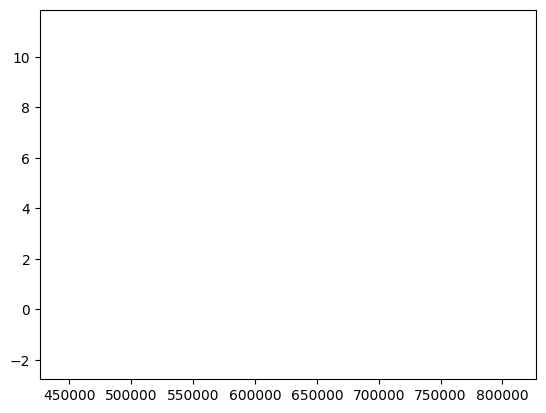

In [74]:
plt.bar(x=X_test.index, height=y_test)

In [ ]:
dr.fit(X_train_nn, y_train_nn)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.7990        2.1813  0.1923
      2        2.0712        1.9098  0.0521
      3        1.7858        1.7311  0.0652


/Users/jason/Local/school/520/moneyball-ml/venv3.12/lib/python3.12/site-packages/skorch/_doctor.py:154: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  rec_param_update[-1][param_name] = (grad.std() / (eps + tensor.std())).item()


      4        1.5707        1.6090  0.0539
      5        1.3876        1.5375  0.0522
      6        1.2601        1.3851  0.0542
      7        1.1688        1.3410  0.0517
      8        1.1104        1.2828  0.0488
      9        1.0656        1.3099  0.0500
     10        1.0304        1.2004  0.0514
     11        1.0112        1.2258  0.0494
     12        0.9825        1.1703  0.0488
     13        0.9627        1.1648  0.0501
     14        0.9387        1.2195  0.0510
     15        0.9143        1.1159  0.0488
     16        0.8979        1.1196  0.0512
     17        0.8810        1.1459  0.0519
     18        0.8586        1.1053  0.0495
     19        0.8376        1.1214  0.0499
     20        0.8114        1.0424  0.0672
     21        0.8047        1.0301  0.0511
     22        0.7929        1.0168  0.0517
     23        0.7706        1.0400  0.0514
     24        0.7545        1.0452  0.0526
     25        0.7442        1.0076  0.0520
     26        0.7296        0.9

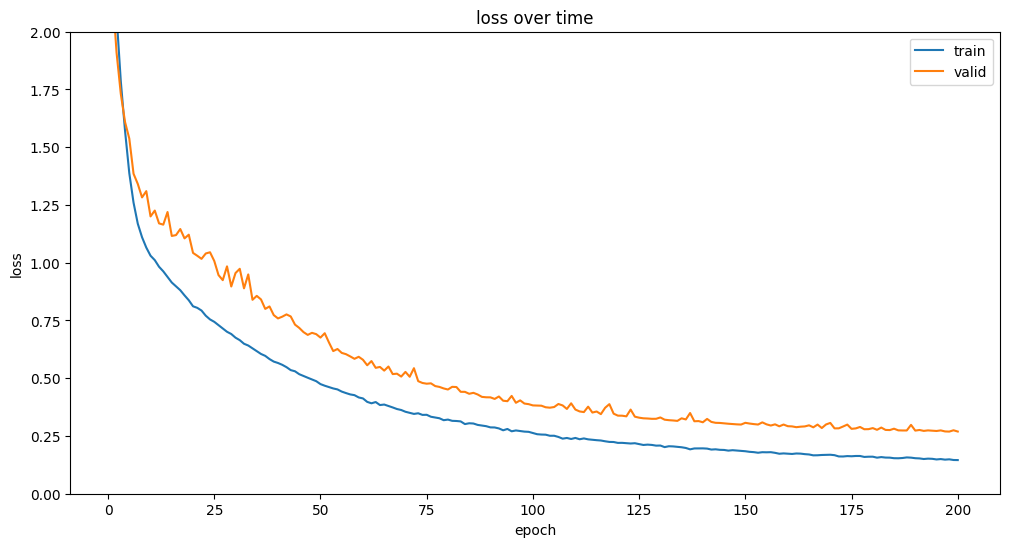

In [63]:
_, ax = plt.subplots(figsize=(12, 6))
dr.plot_loss(ax=ax)
ax.set_ylim([0., 2]);

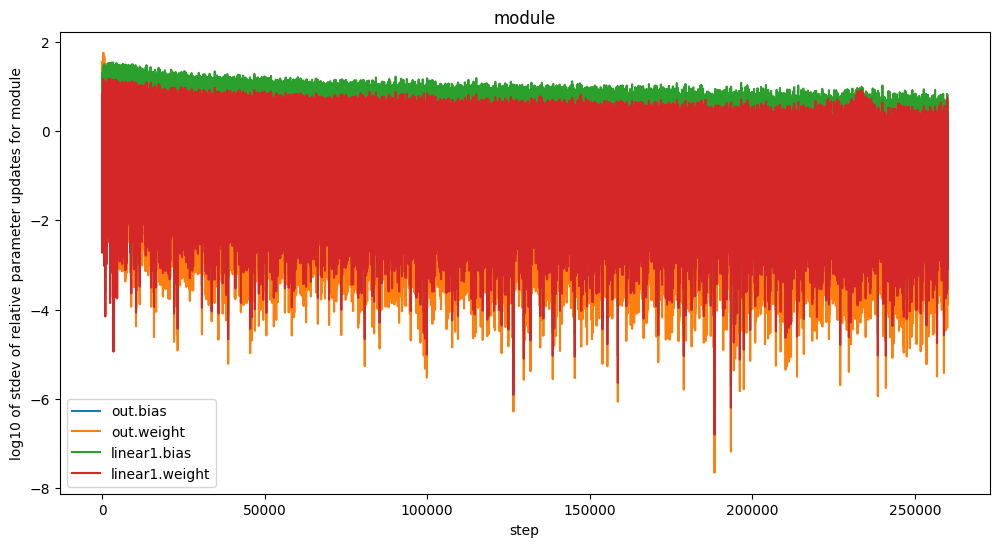

In [42]:
dr.plot_param_updates();

In [ ]:
dr.predict(X_test)

In [13]:
errors = """
1	1.8722
2	1.1527
3	0.9886
4	0.8654
5	0.8041
6	0.7185
7	0.7012
8	0.6358
9	0.5941
10	0.5554
11	0.4936
12	0.4930
13	0.4544
14	0.4146
15	0.3931
16	0.3799
17	0.3683
18	0.3405
19	0.3280
20	0.3166
21	0.2993
22	0.2985
23	0.2818
24	0.2719
25	0.2603
26	0.2494
27	0.2442
28	0.2451
29	0.2361
30	0.2323
31	0.2289
32	0.2217
33	0.2146
34	0.2092
35	0.1939
36	0.1955
37	0.1951
38	0.1918
39	0.1913
40	0.1919
41	0.1856
42	0.1826
43	0.1728
44	0.1772
45	0.174
46	0.1665
47	0.1697
48	0.1608
49	0.1608
50	0.1550
51	0.1550
52	0.1518
53	0.1459
54	0.1471
55	0.1522
56	0.1454
57	0.1432
58	0.1431
59	0.1369
60	0.1415
61	0.1448
62	0.1484
63	0.1401
64	0.1361
65	0.1328
66	0.1309
67	0.1336
68	0.1306
69	0.1291
70	0.1252
71	0.1221
72	0.1309
73	0.1193
74	0.1242
75	0.1258
76	0.1261
77	0.1182
78	0.1222
79	0.1214
80	0.1247
81	0.1229
82	0.1132
83	0.1142
84	0.1152
85	0.1126
86	0.1201
87	0.1134
88	0.1115
89	0.112
90	0.112
91	0.1146
92	0.1065
93	0.1056
94	0.1105
95	0.1072
96	0.1023
97	0.1062
98	0.1069
99	0.1041
100	0.1041
101	0.1036
102	0.0983
103	0.1022
104	0.106
105	0.0993
106	0.0983
107	0.1016
108	0.0958
109	0.0949
110	0.1
111	0.0982
112	0.099
113	0.0940
114	0.097
115	0.0979
116	0.0939
117	0.0977
118	0.0920
119	0.0982
120	0.094
121	0.0912
122	0.0922
123	0.0923
124	0.0942
125	0.0913
126	0.0941
127	0.0919
128	0.0875
129	0.0854
130	0.0892
131	0.0872
132	0.0882
133	0.0852
134	0.092
135	0.0837
136	0.0879
137	0.0855
138	0.0898
139	0.0830
140	0.0814
141	0.0851
142	0.0835
143	0.0810
144	0.0796
145	0.0797
146	0.0799
147	0.0807
148	0.0815
149	0.0780
150	0.0785
151	0.0789
152	0.0770
153	0.0791
154	0.0763
155	0.0746
156	0.0782
157	0.0771
158	0.0792
159	0.075
160	0.0749
161	0.0737
162	0.0764
163	0.0766
164	0.0772
165	0.0739
166	0.0731
167	0.0726
168	0.0758
169	0.0712
170	0.0739
171	0.0743
172	0.0699
173	0.0718
174	0.0696
175	0.0684
176	0.0672
177	0.0677
178	0.0708
179	0.0697
180	0.0706
181	0.0686
182	0.0691
183	0.0656
184	0.0678
185	0.0666
186	0.0647
187	0.0640
188	0.0677
189	0.0636
190	0.064
191	0.0657
192	0.0643
193	0.0634
194	0.066
195	0.0642
196	0.0618
197	0.0601
198	0.0631
199	0.0622
200	0.0643
201	0.0624
202	0.0609
203	0.0619
204	0.0609
205	0.0614
206	0.0605
207	0.0600
208	0.0589
209	0.0584
210	0.061
211	0.0573
212	0.0555
213	0.0575
214	0.0564
215	0.0594
216	0.0556
217	0.0566
218	0.0552
219	0.0563
220	0.0554
221	0.0559
222	0.0566
223	0.0557
224	0.0565
225	0.0548
226	0.0553
227	0.056
228	0.0552
229	0.0539
230	0.0517
231	0.0516
232	0.0534
233	0.0516
234	0.0517
235	0.0516
236	0.0526
237	0.053
238	0.0495
239	0.0494
240	0.0511
241	0.0528
242	0.0518
243	0.0490
244	0.0528
245	0.0515
246	0.0467
247	0.048
248	0.0503
249	0.0477
250	0.048
251	0.0460
252	0.0496
253	0.0478
254	0.0453
255	0.047
256	0.0457
257	0.0435
258	0.0488
259	0.0428
260	0.044
261	0.0455
262	0.0462
263	0.0466
264	0.0444
265	0.045
266	0.0449
267	0.0459
268	0.0448
269	0.0439
270	0.0426
271	0.0445
272	0.0435
273	0.0442
274	0.0434
275	0.0391
276	0.0435
277	0.0403
278	0.0412
279	0.042
280	0.0387
281	0.0409
282	0.0401
283	0.041
284	0.0411
285	0.0412
286	0.0388
287	0.0398
288	0.0391
289	0.0413
290	0.0421
291	0.0385
292	0.04
293	0.0411
294	0.0397
295	0.0371
296	0.0372
297	0.0366
298	0.0387
299	0.0363
300	0.037
301	0.0369
302	0.0375
303	0.0384
304	0.0376
305	0.0373
306	0.0369
307	0.0354
308	0.0351
309	0.038
310	0.0338
311	0.0371
312	0.0335
313	0.0342
314	0.0336
315	0.0348
316	0.0342
317	0.0356
318	0.0338
319	0.0343
320	0.0335
321	0.0339
322	0.0321
323	0.0314
324	0.0338
325	0.0327
326	0.033
327	0.0323
328	0.0323
329	0.0312
330	0.0333
331	0.0332
332	0.0297
333	0.0338
334	0.0325
335	0.032
336	0.0302
337	0.0294
338	0.0304
339	0.0316
340	0.0322
341	0.0297
342	0.0305
343	0.0288
344	0.0305
345	0.0286
346	0.0302
347	0.0289
348	0.0306
349	0.0282
350	0.0278
351	0.0287
352	0.0291
353	0.028
354	0.0282
355	0.0277
356	0.0282
357	0.0278
358	0.0258
359	0.0257
360	0.0271
361	0.0287
362	0.0278
363	0.0273
364	0.027
365	0.0267
366	0.0267
367	0.0271
368	0.0266
369	0.0263
370	0.0251
371	0.0262
372	0.0247
373	0.0257
374	0.0254
375	0.0263
376	0.0244
377	0.0252
378	0.0254
379	0.0248
380	0.0246
381	0.0247
382	0.0245
383	0.0235
384	0.0231
385	0.0238
386	0.0234
387	0.025
388	0.0241
389	0.0233
390	0.0233
391	0.0235
392	0.0216
393	0.022
394	0.0237
395	0.023
396	0.0228
397	0.0219
398	0.0219
399	0.0226
400	0.0222
401	0.0226
402	0.0218
403	0.0217
404	0.022
405	0.0210
406	0.0212
407	0.0211
408	0.0216
409	0.0212
410	0.0217
411	0.0212
412	0.0214
413	0.0208
414	0.0219
415	0.0206
416	0.0209
417	0.0194
418	0.0187
419	0.0194
420	0.0202
421	0.0195
422	0.0196
423	0.0196
424	0.0195
425	0.0198
426	0.0191
427	0.0197
428	0.019
429	0.0197
430	0.0194
431	0.0191
432	0.019
433	0.019
434	0.0184
435	0.0182
436	0.0186
437	0.0181
438	0.0180
439	0.0176
440	0.0178
441	0.018
442	0.0178
443	0.0182
444	0.018
445	0.0179
446	0.0181
447	0.0170
448	0.0167
449	0.0172
450	0.0168
451	0.0169
452	0.0173
453	0.0168
454	0.0160
455	0.0166
456	0.0166
457	0.0167
458	0.0162
459	0.0162
460	0.0152
461	0.0159
462	0.0154
463	0.0156
464	0.0163
465	0.0153
466	0.0161
467	0.0156
468	0.0158
469	0.0159
470	0.0148
471	0.0147
472	0.0154
473	0.0152
474	0.015
475	0.0152
476	0.0149
477	0.0147
478	0.0153
479	0.0140
480	0.0144
481	0.0143
482	0.0148
483	0.014
484	0.0147
485	0.0137
486	0.0144
487	0.0138
488	0.0142
489	0.0139
490	0.0135
491	0.0139
492	0.0133
493	0.0134
494	0.0131
495	0.0138
496	0.0136
497	0.0134
498	0.0130
499	0.0130
500	0.0133
501	0.0132
502	0.0132
503	0.0119
504	0.0133
505	0.0127
506	0.0131
507	0.0118
508	0.0124
509	0.0129
510	0.0127
511	0.0125
512	0.0119
513	0.0127
514	0.0121
515	0.0123
516	0.0119
517	0.0118
518	0.012
519	0.0124
520	0.0124
521	0.0114
522	0.0115
523	0.0115
524	0.0114
525	0.0113
526	0.0111
527	0.0114
528	0.0111
529	0.0116
530	0.0111
531	0.0111
532	0.0112
533	0.0107
534	0.0109
535	0.0104
536	0.0111
537	0.0109
538	0.0108
539	0.0101
540	0.011
541	0.0107
542	0.0107
543	0.0106
544	0.0106
545	0.0106
546	0.0105
547	0.0107
548	0.0106
549	0.0100
550	0.0102
551	0.0104
552	0.0101
553	0.0102
554	0.0102
555	0.0098
556	0.0097
557	0.0106
558	0.01
559	0.0103
560	0.0097
561	0.0096
562	0.0093
563	0.0095
564	0.0096
565	0.0094
566	0.0095
567	0.0096
568	0.0092
569	0.0090
570	0.0093
571	0.0093
572	0.0094
573	0.0093
574	0.0094
575	0.0093
576	0.0087
577	0.0091
578	0.009
579	0.0093
580	0.0086
581	0.009
582	0.0086
583	0.0089
584	0.0084
585	0.0083
586	0.0086
587	0.0087
588	0.0086
589	0.0086
590	0.0088
591	0.0089
592	0.009
593	0.0091
594	0.0094
595	0.0092
596	0.009
597	0.009
598	0.0087
599	0.0091
600	0.0099
601	0.0094
602	0.0099
603	0.0104
604	0.0108
605	0.0114
606	0.0124
607	0.0121
608	0.0129
609	0.0127
610	0.0103
611	0.0116
612	0.0102
613	0.0093
614	0.0091
615	0.0084
616	0.0080
617	0.008
618	0.0078
619	0.008
620	0.0077
621	0.0078
622	0.0077
623	0.0076
624	0.0074
625	0.0075
626	0.0074
627	0.0081
628	0.0082
629	0.0081
630	0.0076
631	0.0078
632	0.0077
633	0.0077
634	0.0075
635	0.0077
636	0.0068
637	0.007
638	0.0072
639	0.0071
640	0.0068
641	0.0065
642	0.0066
643	0.0069
644	0.0067
645	0.0068
646	0.0064
647	0.0065
648	0.0065
649	0.0065
650	0.0065
651	0.0063
652	0.0064
653	0.0062
654	0.0063
655	0.0067
656	0.0062
657	0.0065
658	0.0063
659	0.0059
660	0.0061
661	0.0063
662	0.0061
663	0.006
664	0.0061
665	0.0061
666	0.0058
667	0.0061
668	0.0058
669	0.006
670	0.0061
671	0.006
672	0.006
673	0.0058
674	0.0059
675	0.0059
676	0.0057
677	0.0057
678	0.0058
679	0.0058
680	0.0058
681	0.0059
682	0.0058
683	0.0058
684	0.0059
685	0.0056
686	0.0057
687	0.0057
688	0.0054
689	0.0053
690	0.0053
691	0.0053
692	0.0053
693	0.0052
694	0.0053
695	0.0053
696	0.0053
697	0.0051
698	0.0051
699	0.0051
700	0.0052
701	0.0054
702	0.0050
703	0.0051
704	0.005
705	0.0052
706	0.0049
707	0.0052
708	0.005
709	0.0051
710	0.005
711	0.005
712	0.0048
713	0.0053
714	0.0054
715	0.0052
716	0.0053
717	0.0052
718	0.0052
719	0.0049
720	0.0049
721	0.0048
722	0.0048
723	0.0048
724	0.0048
725	0.0045
726	0.0046
727	0.0047
728	0.0045
729	0.0045
730	0.0047
731	0.0046
732	0.0045
733	0.0046
734	0.0046
735	0.0044
736	0.0045
737	0.0042
738	0.0045
739	0.0045
740	0.0041
741	0.0045
742	0.0044
743	0.0045
744	0.0044
745	0.0043
746	0.0045
747	0.0043
748	0.0043
749	0.0044
750	0.0043
751	0.0043
752	0.0042
753	0.0043
754	0.0041
755	0.0042
756	0.0042
757	0.0042
758	0.0042
759	0.0041
760	0.0042
761	0.0043
762	0.0039
763	0.0042
764	0.004
765	0.0046
766	0.0044
767	0.0042
768	0.0042
769	0.0043
770	0.0043
771	0.0041
772	0.0043
773	0.0041
774	0.0043
775	0.0044
776	0.0042
777	0.0042
778	0.0039
779	0.0038
780	0.004
781	0.0039
782	0.0041
783	0.0042
784	0.0042
785	0.0042
786	0.0044
787	0.0046
788	0.0042
789	0.004
790	0.0042
791	0.0039
792	0.0039
793	0.004
794	0.004
795	0.004
796	0.0038
797	0.004
798	0.004
799	0.0041
800	0.0041
801	0.0042
802	0.0043
803	0.0045
804	0.0046
805	0.0045
806	0.0043
807	0.0042
808	0.0043
809	0.0046
810	0.0042
811	0.0043
812	0.0041
813	0.0039
814	0.0037
815	0.0036
816	0.0036
817	0.0036
818	0.0037
819	0.0038
820	0.0038
821	0.0039
822	0.0037
823	0.0035
824	0.0035
825	0.0035
826	0.0034
827	0.0033
828	0.0032
829	0.0034
830	0.0033
831	0.0034
832	0.0034
833	0.0033
834	0.0032
835	0.0032
836	0.0032
837	0.0034
838	0.0032
839	0.0032
840	0.0033
841	0.0032
842	0.0032
843	0.0031
844	0.0031
845	0.0031
846	0.0030
847	0.0032
848	0.0031
849	0.0031
850	0.0032
851	0.0031
852	0.0032
853	0.0030
854	0.0029
855	0.0029
856	0.0029
857	0.0031
858	0.0031
859	0.0032
860	0.0032
861	0.0032
862	0.003
863	0.0032
864	0.0034
865	0.0035
866	0.0036
867	0.0035
868	0.0035
869	0.0037
870	0.0036
871	0.0035
872	0.0037
873	0.0045
874	0.0046
875	0.0048
876	0.0049
877	0.0049
878	0.0051
879	0.005
880	0.0048
881	0.0051
882	0.005
883	0.0052
884	0.0062
885	0.0058
886	0.0052
887	0.0051
888	0.0055
889	0.0064
890	0.0062
891	0.0063
892	0.0061
893	0.0061
894	0.006
895	0.0066
896	0.0059
897	0.0057
898	0.0052
899	0.0049
900	0.0051
901	0.0046
902	0.0048
903	0.0046
904	0.0048
905	0.0045
906	0.0039
907	0.0039
908	0.0038
909	0.0037
910	0.0036
911	0.0037
912	0.0035
913	0.0032
914	0.003
915	0.003
916	0.0032
917	0.003
918	0.0029
919	0.0028
920	0.0028
921	0.0027
922	0.0025
923	0.0026
924	0.0025
925	0.0025
926	0.0025
927	0.0024
928	0.0024
929	0.0025
930	0.0024
931	0.0026
932	0.0025
933	0.0028
934	0.0026
935	0.0024
936	0.0026
937	0.0026
938	0.0024
939	0.0023
940	0.0023
941	0.0023
942	0.0023
943	0.0023
944	0.0023
945	0.0024
946	0.0022
947	0.0021
948	0.0022
949	0.0022
950	0.0021
951	0.0021
952	0.0022
953	0.0021
954	0.0021
955	0.0021
956	0.0021
957	0.0021
958	0.0021
959	0.0022
960	0.0021
961	0.0021
962	0.0021
963	0.0021
964	0.0021
965	0.0021
966	0.0020
967	0.0021
968	0.0021
969	0.002
970	0.0020
971	0.0021
972	0.0021
973	0.0020
974	0.0021
975	0.0021
976	0.0021
977	0.0021
978	0.0022
979	0.0021
980	0.0021
981	0.0022
982	0.0022
983	0.0022
984	0.0021
985	0.0023
986	0.0022
987	0.0022
988	0.0021
989	0.0024
990	0.0024
991	0.0023
992	0.0023
993	0.0023
994	0.0022
995	0.0022
996	0.0022
997	0.0021
998	0.0020
"""

NN doctor and eval

In [32]:
epochs = []
mses = [] 
for err in errors.splitlines(): 
    splits = err.split(sep="\t")
    if len(splits) == 2: 
        mses.append(float(splits[1]))
        epochs.append(int(splits[0]))

In [26]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'MSE')

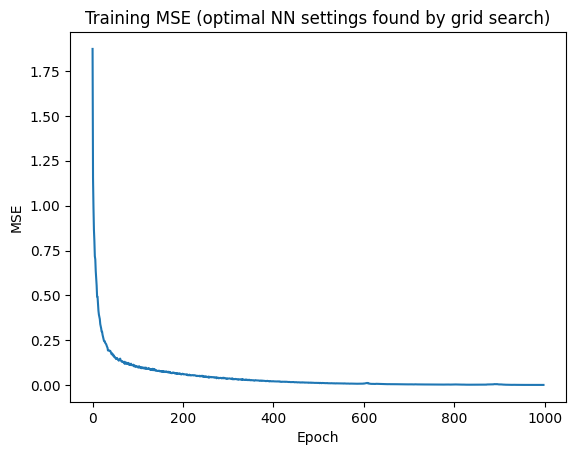

In [ ]:
plt.plot(mses)
plt.title("Training MSE (optimal NN settings found by grid search)")
plt.xlabel("Epoch")
plt.ylabel("MSE")

array([[<Axes: title={'center': 'distribution of gradients for module'}>]],
      dtype=object)

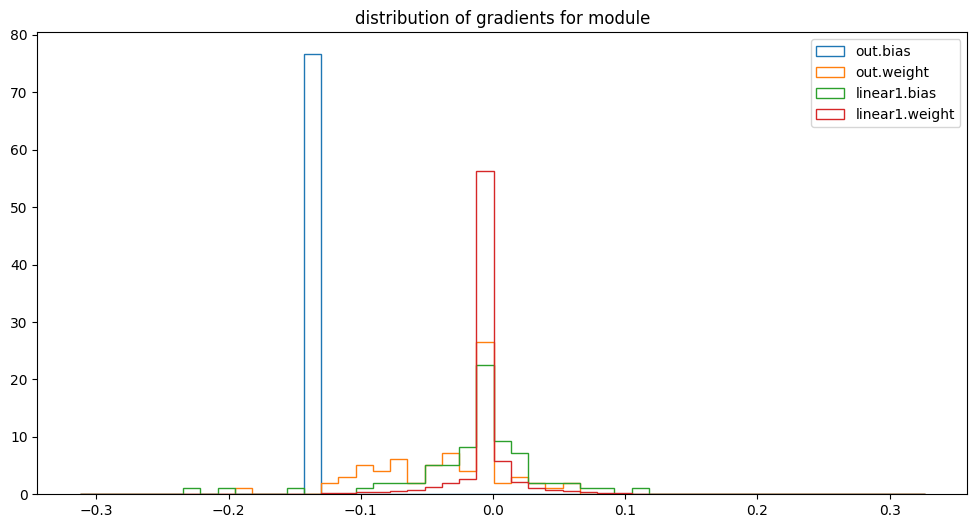

In [52]:
dr.plot_gradients()

array([[<Axes: title={'center': 'module'}, xlabel='step', ylabel='log10 of stdev of relative parameter updates for module'>]],
      dtype=object)

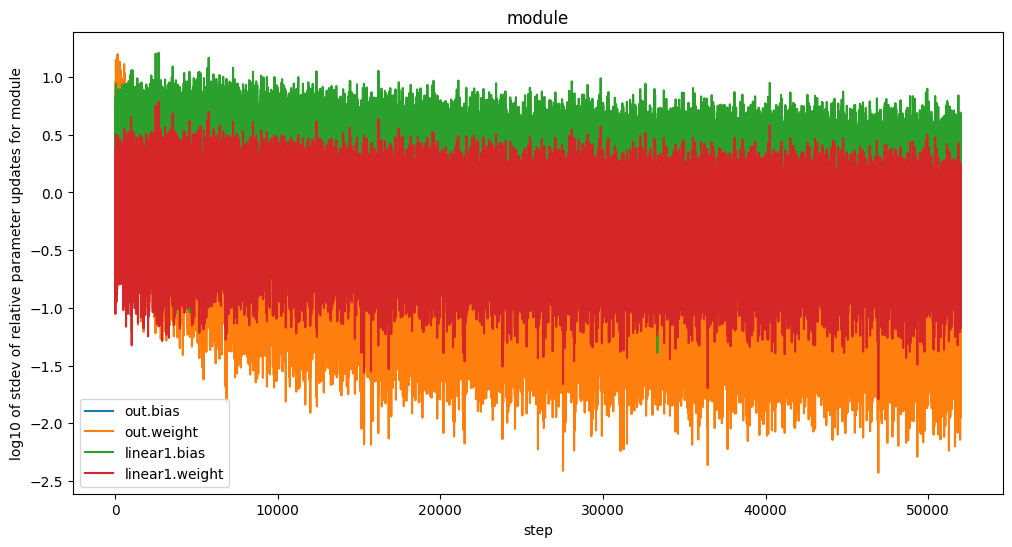

In [53]:
dr.plot_param_updates()

<Axes: title={'center': 'distribution of activations for linear1 of module'}, ylabel='step / activation'>

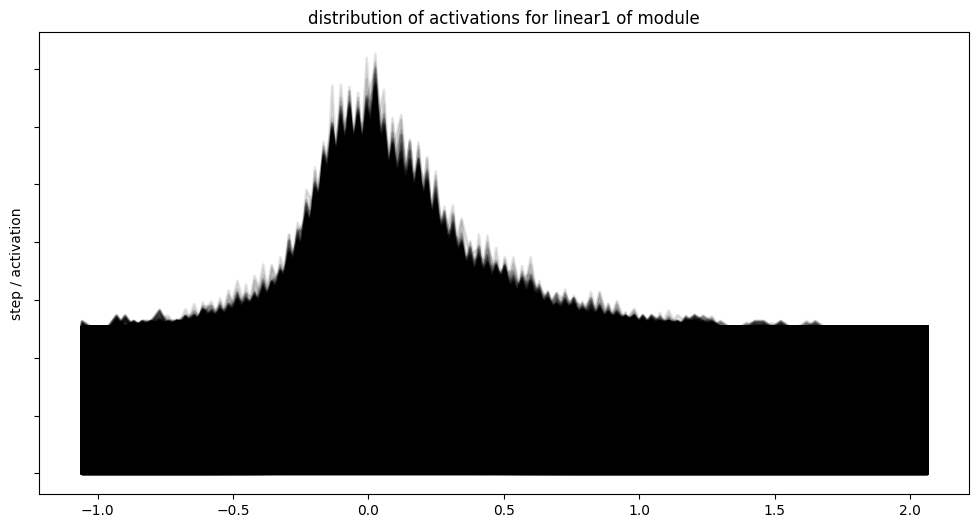

In [ ]:
# Danger, CPU time suck!
#dr.plot_activations_over_time('linear1')

In [498]:
preds = dr.predict(test)

In [499]:
X_test.shape

(559, 339)

In [501]:
import sklearn
sklearn.metrics.mean_squared_error(y_test, preds)

0.46781253814697266